In [1]:
!pip install matplotlib numpy librosa requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.0/390.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 29.4 MB/s eta 0:00:0000:0100:01


In [4]:
import os
import sys


#os.chdir("/Users/timothee-l/Documents/CPE/5ETI/Projet/IA/Training")

Song download/Spectral extraction function

In [1]:
import requests
import numpy as np
import io
import librosa
import librosa.display
import matplotlib.pyplot as plt

def download_audio(url):
    response = requests.get(url)
    return io.BytesIO(response.content)

def extract_mfcc_in_memory(audio_data, num_mfcc=20):
    y, sr = librosa.load(audio_data, sr=None)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)

    return mfccs

Load tracks from json

In [5]:
import json


songs = []

def lookup_category(genre):
    categories = {"house": ["afro-house", "bass-club", "bass-house", "deep-house", "funky-house", "house", "jackin-house","melodic-house-techno", "organic-house-downtempo", "progressive-house", "tech-house"],
        "techno": ["techno-peak-time-driving", "techno-raw-deep-hypnotic", "hard-techno"],
        "trance": ["trance-main-floor", "trance-raw-deep-hypnotic", "psy-trance"],
        "dubstep": ["140-deep-dubstep-grime", "drum-bass", "dubstep"],
        "edm": ["electro-classic-detroit-modern", "mainstage"],
        "dance": ["dance-electro-pop", "indie-dance", "hardcore"]}
    
    for category, subgenres in categories.items():
        if genre in subgenres:
            return category
    return None


with open("tracks.json") as f:
    songs_raw = json.load(f)
    
    limit = 100
    i = 0
    
    for song_raw in songs_raw:
        i +=1
        if i >= limit:
            break
        try:
            song = {"id": song_raw["id"],
                    "bpm": song_raw["bpm"],
                    "camelot_key": f'{song_raw["key"]["camelot_number"]}{song_raw["key"]["camelot_letter"]}',
                    "genre": song_raw["genre"]["slug"],
                    "category": lookup_category(song_raw["genre"]["slug"]),}
            if "sub_genre" in song_raw:
                song["sub_genre"] = song_raw["sub_genre"]
            else:
                song["sub_genre"] = None
                
            audio_data = download_audio(song_raw["sample_url"])
            mfcc = extract_mfcc_in_memory(audio_data)
            song["mfcc"] = mfcc
            
        except TypeError:
            # Incomplete data
            continue
        except Exception:
            # Unable to read audio file (or other)
            continue
        songs.append(song)

print(f"Total songs: {len(songs)}")

Total songs: 97


Plotting some info about the dataset

In [27]:
print(sys.getsizeof(songs))

920


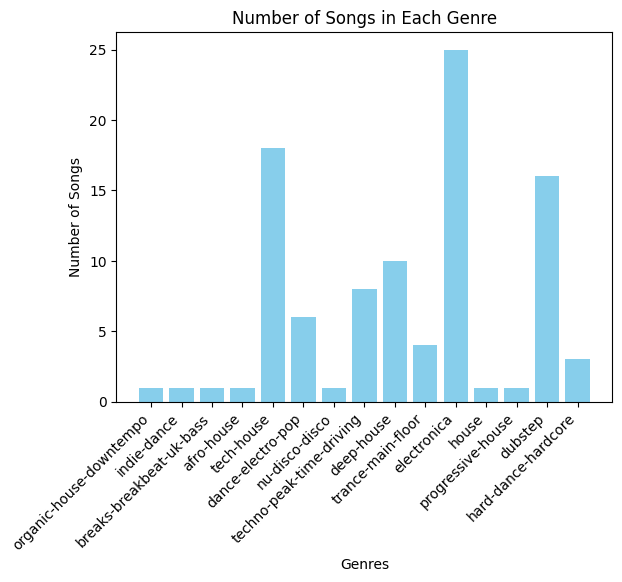

In [6]:
import matplotlib.pyplot as plt


genre_counts = {}
for song in songs:
    genre = song["genre"]
    genre_counts[genre] = genre_counts.get(genre, 0) + 1

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.bar(genres, counts, color='skyblue')
plt.xlabel('Genres')
plt.xticks(rotation=45, ha="right")
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Genre')
plt.show()

Defining distance function
Calculating distances for each set of pairs

In [7]:
def compute_metadata_distance(song1, song2):
    camelot_wheel = ['1A', '2A', '3A', '4A', '5A', '6A', '7A', '8A', '9A', '10A', '11A', '12A',
                     '1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', '11B', '12B']

    index1 = camelot_wheel.index(song1["camelot_key"].upper())
    index2 = camelot_wheel.index(song2["camelot_key"].upper())

    identical = index1 == index2
    adjacent = abs(index1 - index2) == 1 or abs(index1 - index2) == len(camelot_wheel) - 1

    bpm_difference = abs(song1['bpm'] - song2['bpm'])

    same_subgenre = song1['sub_genre'] == song2['sub_genre'] or song1['sub_genre'] is None
    same_genre = song1['genre'] == song2['genre']
    same_category = song1['category'] == song2['category'] or song1['category'] is None
    
    # TODO: optimize weights
    distance = ((not identical and not adjacent)
                + 0.3 * bpm_difference
                + 0.3 * (not same_category)
                + 0.3 * (not same_genre)
                + 0.3 * (not same_subgenre))

    return distance

In [16]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_spectral_distance(songA, songB):
    song1_mfcc = songA["mfcc"]
    song2_mfcc = songB["mfcc"]
    
    min_frames = min(song1_mfcc.shape[1], song2_mfcc.shape[1])
    song1_mfcc = song1_mfcc[:, :min_frames]
    song2_mfcc = song2_mfcc[:, :min_frames]

    # Reshape MFCC arrays to a 1D array for cosine similarity calculation
    song1_flat = song1_mfcc.flatten().reshape(1, -1)
    song2_flat = song2_mfcc.flatten().reshape(1, -1)

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(song1_flat, song2_flat)
    
    # The similarity value is in the range [-1, 1], where 1 indicates identical MFCCs
    similarity_value = similarity_matrix[0, 0]
    
    return similarity_value

In [17]:
import numpy as np
import matplotlib.pyplot as plt


distance_metadata = []
distance_spectral = []
for songA in songs:
    for songB in songs:
        if songA != songB:
            distance_metadata.append(compute_metadata_distance(songA, songB))
            distance_spectral.append(compute_spectral_distance(songA, songB))

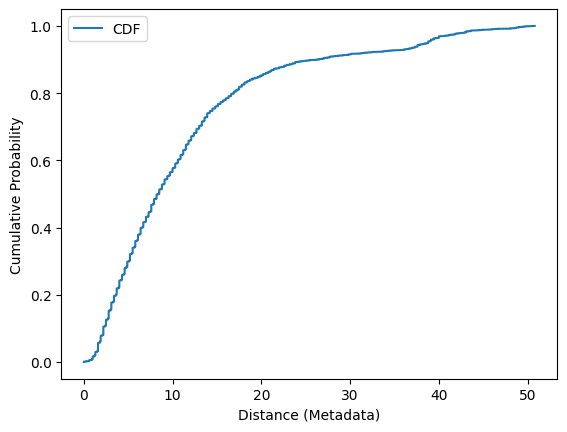

In [18]:
sorted_distances = np.sort(distance_metadata)
cumulative_distribution = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)

plt.plot(sorted_distances, cumulative_distribution, label='CDF')

plt.xlabel('Distance (Metadata)')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.show()

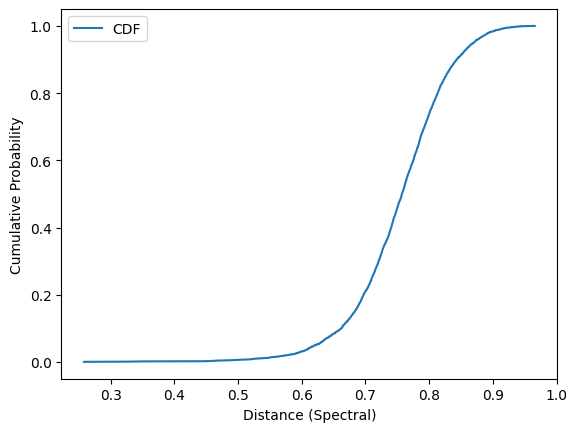

In [19]:
sorted_distances_spectral = np.sort(distance_spectral)
cumulative_distribution_spectral = np.arange(1, len(sorted_distances_spectral) + 1) / len(sorted_distances_spectral)

plt.plot(sorted_distances_spectral, cumulative_distribution_spectral, label='CDF')

plt.xlabel('Distance (Spectral)')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.show()

Comparing the two methods:
Correlation is poor

In [25]:
from scipy.stats import pearsonr, spearmanr

# Normalize

max_value_metadata = np.max(distance_metadata)
normalized_dist_metadata = distance_metadata / max_value_metadata

normalized_dist_spectral = [(x + 1) / 2 for x in distance_spectral]


correlation, _ = pearsonr(normalized_dist_metadata, normalized_dist_spectral)
spearman_correlation, _ = spearmanr(normalized_dist_metadata, normalized_dist_spectral)

print(f"Pearson Correlation: {correlation}")
print(f"Spearman Correlation: {spearman_correlation}")

Pearson Correlation: -0.09531226989479602
Spearman Correlation: -0.010906111887350089


Overall distance

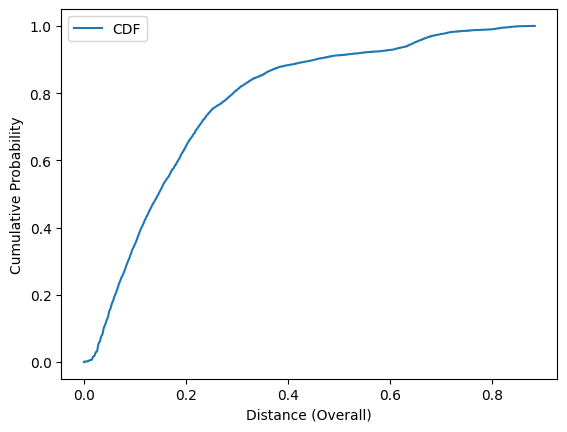

In [26]:
distance = [x * y for x, y in zip(normalized_dist_metadata, normalized_dist_spectral)]

sorted_distances_overall = np.sort(distance)
cumulative_distribution_overall = np.arange(1, len(sorted_distances_overall) + 1) / len(sorted_distances_overall)

plt.plot(sorted_distances_overall, cumulative_distribution_overall, label='CDF')

plt.xlabel('Distance (Overall)')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.show()

Getting the match score

In [15]:
def get_match_score(distance):
    index = np.argmax(sorted_distances >= target_distance)
    
    percentage_above_distance = 100 * (1 - (index / len(sorted_distances)))

    return percentage_above_distance

Testing with a random pair

In [18]:
from random import randrange

songA = songs[randrange(len(songs))]
songB = songs[randrange(len(songs))]

distance = compute_metadata_distance(songA, songB)
score = get_match_score(distance)
print(f"Distance: {distance}; Score: {score}")

Distance: 10.900000000000002; Score: 31.880853618468464


Saving distances to file

In [21]:
np.save('./distances.npy', sorted_distances)

# TODO: Calcul distance mfc
# Les plots comme pour la distance metadata
# Comparer la distance metadata et la distance spectrale
# Relation entre les 2?